# Minesweeper Bot Analysis
Primarily an analysis of my probabilistic strategy.

Insights:
1. Runtime by density
2. Win rate by density
3. Turns taken to win by density
    - How many tiles are cleared?
4. Turns taken to lose by density
    - How many tiles are cleared?
    - How many tiles are left?

Import dependencies

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

Read data

In [8]:
filename = "mediumsize.csv"
df = pd.read_csv("../data/" + filename)
df.head()

,numRows,numColumns,initialDensity,numMines,status,numMoves,numTilesCleared,elapsedMillis
0,9,9,0.0,0,WIN,1,81,26
1,9,9,0.0,0,WIN,1,81,2
2,9,9,0.0,0,WIN,1,81,2
3,9,9,0.0,0,WIN,1,81,3
4,9,9,0.0,0,WIN,1,81,2


### About the data
The output of the following is an overview of the data collection process.

In [72]:
print("Max rows: " + df.numRows.max().astype(str))
print("Max columns: " + df.numColumns.max().astype(str))
print("Distinct densities: " + (1 + df.numRows.max() * df.numColumns.max()).astype(str))
print("Avg. Number of trials: " + df.groupby("numMines").size().min().astype(str))
print("Number of games simulated: " + str(len(df.index)))


Max rows: 9
Max columns: 9
Distinct densities: 82
Avg. Number of trials: 5000
Number of games simulated: 410000


### Some helper functions

These are the densities of the different difficulties:
- $\rho_\text{easy} = 0.1234567901$. (9x9)
- $\rho_\text{medium} = 0.15625$. (16x16)
- $\rho_\text{hard} = 0.20625$. (16x30)
- $\rho_\text{expert} = 0.25$. (24x3)

<u>Main idea:</u> We can use the data to approximate the win rates of the probabilistic algorithm for the different difficulty games 

In [41]:
densities = {
    "easy": 0.1234567901, 
    "medium": 0.15625, 
    "hard": 0.20625, 
    "expert": 0.25
}

Function to get the rows of a DataFrame with intialDensity = density ± epsilon

In [42]:
def has_density(df, density, epsilon = 0.005):
    return df[(df["initialDensity"] >= (density - epsilon)) & (df["initialDensity"] <= (density + epsilon))]

Function that returns a dataframe with rows with all initialDensity = density ± epsilon for each density in a passed in dictionary of difficulty:density mapping

In [43]:
def has_densities(df, densities = densities, epsilon = 0.005):
    filtered_rows = []
    for difficulty, density in densities.items():
        filtered_rows.append(has_density(df, density, epsilon).assign(approxDifficulty = difficulty))
    return pd.concat(filtered_rows, ignore_index = True)

Function that returns a DataFrame with a new column which holds the normalized values of a given column, based on a known "key" cell, e.g. difficulty = "easy". Thus, we can do something like normalize runtime based on the runtime of the "easy" difficulty.

This gives us insight into things like how much slower/faster the runtime is relative to the easy difficulty.

In [44]:
def normalize_column_by_key(df, column_to_normalize: str, key_column: str = "approxDifficulty", key_value: str = "easy"):
    df_norm = df.copy()
    df_norm[column_to_normalize + "Normalized"] = df_norm[column_to_normalize] / df_norm.loc[df[key_column] == key_value, column_to_normalize].values[0]
    return df_norm

Similar, but instead we normalize by the minimum value in the column we are normalizing

In [45]:
def normalize_column_by_min(df, column_to_normalize: str):
    return normalize_column_by_key(df, column_to_normalize, column_to_normalize, df[column_to_normalize].min())


Function that:
1. Finds rows that have given density values
2. Normalizes by a given "key"

In [46]:
def approx_difficulty_and_normalize_column_by_key(df, column_to_normalize, key_column: str = "approxDifficulty", key_value: str = "easy"):
    return df.pipe(has_densities).pipe(normalize_column_by_key, column_to_normalize, key_column, key_value)

In [47]:
def approx_difficulty_and_normalize_column_by_min(df, column_to_normalize):
    return df.pipe(has_densities).pipe(normalize_column_by_min, column_to_normalize)

Function to plot a column by density

In [48]:
def plot_column_by_density(df, column, y_label):
    plt.plot(df["initialDensity"], df[column])
    plt.xlabel("Density")
    plt.ylabel(y_label)
    plt.title(y_label + " vs Density")
    plt.show()

### 1. Win rate

Function to calculate the win rate per group

In [49]:
def win_rate(group):
    return pd.Series({"winRate": len(group[group["status"] == "WIN"]) / len(group["status"])})

Group by initial density and then find the win rate by density by applying the above function

In [50]:
winrate_df = df.groupby(["initialDensity"]).apply(lambda x : win_rate(x))["winRate"].reset_index()

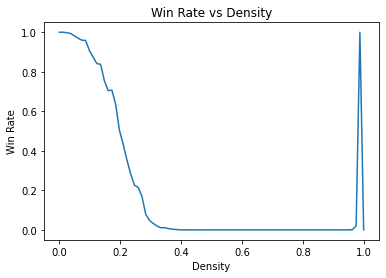

In [51]:
plot_column_by_density(winrate_df, "winRate", "Win Rate")

There is a spike at numMines = 80 because we are guaranteed to start on a non-mine, and this is the only non-mine there is.

Here we see the win rates for the approximate difficulties

In [52]:
approx_difficulty_and_normalize_column_by_key(winrate_df, "winRate")

,initialDensity,winRate,approxDifficulty,winRateNormalized
0,0.123457,0.8414,easy,1.000000
1,0.160494,0.7048,medium,0.837652
2,0.209877,0.4344,hard,0.516282
3,0.246914,0.2260,expert,0.268600


Normalizing by the minimum might give us a better idea:

In [53]:
approx_difficulty_and_normalize_column_by_min(winrate_df, "winRate")

,initialDensity,winRate,approxDifficulty,winRateNormalized
0,0.123457,0.8414,easy,3.723009
1,0.160494,0.7048,medium,3.118584
2,0.209877,0.4344,hard,1.922124
3,0.246914,0.2260,expert,1.000000


Relative to expert difficulty, we win around 3.8x as much in easy, 3.4x in medium, and 1.9x in hard.

Let's try to find the maximal density such that winRate > 0

In [54]:
winrate_df[winrate_df["winRate"] > 0].tail()

,initialDensity,winRate
36,0.444444,0.0002
77,0.950617,0.0004
78,0.962963,0.0012
79,0.975309,0.0212
80,0.987654,1.0000


So, we see that 0.4075 and 0.9753 are the maximal densities such that we can win (besides the trivial 80)

### 2. Runtime

In [55]:
mean_runtime_df = df.groupby(["initialDensity"]).mean("elapsedMillis")["elapsedMillis"].reset_index()
mean_runtime_df_winners = df[df["status"] == "WIN"].groupby(["initialDensity"]).mean("elapsedMillis")["elapsedMillis"].reset_index()
mean_runtime_df_losers = df[df["status"] == "LOSE"].groupby(["initialDensity"]).mean("elapsedMillis")["elapsedMillis"].reset_index()

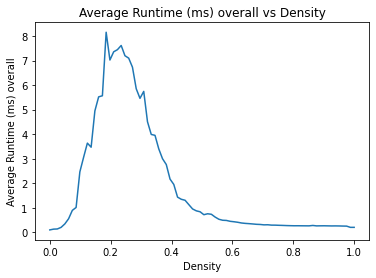

In [56]:
plot_column_by_density(mean_runtime_df, "elapsedMillis", "Average Runtime (ms) overall")

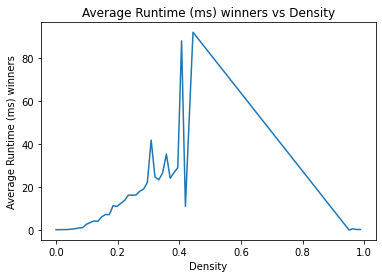

In [57]:
plot_column_by_density(mean_runtime_df_winners, "elapsedMillis", "Average Runtime (ms) winners")

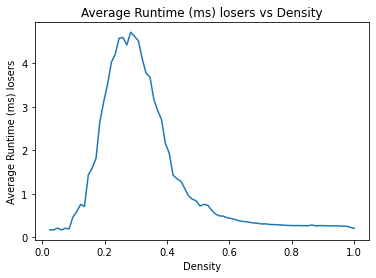

In [58]:
plot_column_by_density(mean_runtime_df_losers, "elapsedMillis", "Average Runtime (ms) losers")

Normalized runtime by the runtime of the "easy" approximate difficulty.

In [59]:
approx_difficulty_and_normalize_column_by_key(mean_runtime_df, "elapsedMillis")

,initialDensity,elapsedMillis,approxDifficulty,elapsedMillisNormalized
0,0.123457,3.6352,easy,1.000000
1,0.160494,5.5206,medium,1.518651
2,0.209877,7.3566,hard,2.023713
3,0.246914,7.1970,expert,1.979809


Winners only:

In [60]:
approx_difficulty_and_normalize_column_by_key(mean_runtime_df_winners, "elapsedMillis")

,initialDensity,elapsedMillis,approxDifficulty,elapsedMillisNormalized
0,0.123457,4.178512,easy,1.000000
1,0.160494,7.165721,medium,1.714898
2,0.209877,12.340700,hard,2.953372
3,0.246914,16.154867,expert,3.866177


Losers only:

In [61]:
approx_difficulty_and_normalize_column_by_key(mean_runtime_df_losers, "elapsedMillis")

,initialDensity,elapsedMillis,approxDifficulty,elapsedMillisNormalized
0,0.123457,0.752837,easy,1.000000
1,0.160494,1.592818,medium,2.115754
2,0.209877,3.528642,hard,4.687124
3,0.246914,4.581395,expert,6.085505


### 3. Number of moves

Mean turns of all games

In [62]:
mean_turns_df = df.groupby(["initialDensity"]).mean("numMoves")["numMoves"].reset_index()

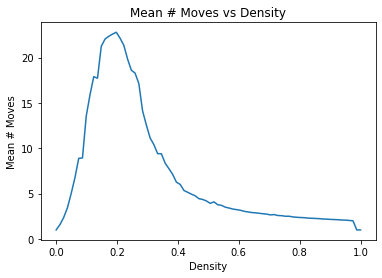

In [63]:
plot_column_by_density(mean_turns_df, "numMoves", "Mean # Moves")

Normalized data

In [64]:
approx_difficulty_and_normalize_column_by_key(mean_turns_df, "numMoves")

,initialDensity,numMoves,approxDifficulty,numMovesNormalized
0,0.123457,17.8932,easy,1.000000
1,0.160494,22.0334,medium,1.231384
2,0.209877,22.1350,hard,1.237062
3,0.246914,18.6040,expert,1.039725


Mean turns of winners

In [65]:
mean_turns_winners = df[df["status"] == "WIN"].groupby(["initialDensity"]).mean("numMoves")["numMoves"].reset_index()

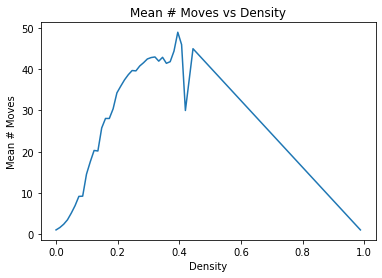

In [66]:
plot_column_by_density(mean_turns_winners, "numMoves", "Mean # Moves")

In [67]:
approx_difficulty_and_normalize_column_by_key(mean_turns_winners, "numMoves")

,initialDensity,numMoves,approxDifficulty,numMovesNormalized
0,0.123457,20.292608,easy,1.000000
1,0.160494,28.064699,medium,1.383001
2,0.209877,35.898250,hard,1.769031
3,0.246914,39.700885,expert,1.956421


##### Mean turns of losers

In [68]:
mean_turns_losers = df[df["status"] == "LOSE"].groupby(["initialDensity"]).mean("numMoves")["numMoves"].reset_index()

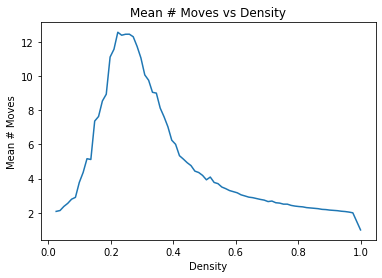

In [69]:
plot_column_by_density(mean_turns_losers, "numMoves", "Mean # Moves")

In [70]:
approx_difficulty_and_normalize_column_by_key(mean_turns_losers, "numMoves")

,initialDensity,numMoves,approxDifficulty,numMovesNormalized
0,0.123457,5.163934,easy,1.000000
1,0.160494,7.633469,medium,1.478227
2,0.209877,11.564356,hard,2.239447
3,0.246914,12.443928,expert,2.409776
